# Stage 2 Calibration Smoothing Nightly Notebook

**Josh Dillon**, Last Revised 12/4/20

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from hera_cal import io, redcal, apply_cal, abscal, utils
from hera_cal.smooth_cal import build_time_blacklist
from hera_qm.metrics_io import load_metric_file
import pyuvdata
import glob
import os
from copy import deepcopy
import inspect
import h5py
import matplotlib.cm as cm
from IPython.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# If you want to run this notebook locally, copy the output of the next cell into the first few lines of this cell.

# JD = '2459122'
# data_path = '/lustre/aoc/projects/hera/H4C/2459122'
# lst_blacklist_string = '0-1.3 2.5-4.3 5.0-5.7 6.5-9.1 10.6-11.5 11.9-14.3 16.3-1.3'
# abscal_model_glob = '/lustre/aoc/projects/hera/zmartino/hera_calib_model/H3C/abscal_files_unique_baselines/zen.2458894.?????.uvh5'
# os.environ["JULIANDATE"] = JD
# os.environ["DATA_PATH"] = data_path
# os.environ["LST_BLACKLIST_STRING"] = lst_blacklist_string
# os.environ["ABSCAL_MODEL_GLOB"] = abscal_model_glob

In [3]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
lst_blacklist_string = os.environ['LST_BLACKLIST_STRING']
abscal_model_glob = os.environ['ABSCAL_MODEL_GLOB']
print(f'JD = "{JD}"')
print(f'data_path = "{data_path}"')
print(f'lst_blacklist_string = "{lst_blacklist_string}"')
print(f'abscal_model_glob = "{abscal_model_glob}"')

JD = "2458190"
data_path = "/lustre/aoc/projects/hera/Validation/test-4.1.0/2458190"
lst_blacklist_string = ""
abscal_model_glob = "/lustre/aoc/projects/hera/Validation/test-4.1.0/abscal_model/zen.245804*.abscal_model.smoothed.uvh5"


In [4]:
from astropy.time import Time
utc = Time(JD, format='jd').datetime
print(f'Date: {utc.month}-{utc.day}-{utc.year}')

Date: 3-12-2018


In [5]:
print('Looking for data in', data_path, 'on JD', JD)
data_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.?????.sum.uvh5')))
if len(data_list) == 0:
    data_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.?????.uvh5')))
print('...found {} data files.'.format(len(data_list)))

abscal_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.*.abs.calfits')))
print('...found {} abscal files.'.format(len(abscal_list)))

smooth_cal_list = sorted(glob.glob(os.path.join(data_path, f'zen.{JD}.*.sum.smooth_abs.calfits')))
print('...found {} smooth_cal files.'.format(len(smooth_cal_list)))

Looking for data in /lustre/aoc/projects/hera/Validation/test-4.1.0/2458190 on JD 2458190
...found 73 data files.
...found 73 abscal files.
...found 73 smooth_cal files.


In [6]:
# get all JDs and LSTs
_, _, file_lst_arrays, file_time_arrays = io.get_file_times(data_list)
# parse lst_blacklist_string
lst_blacklists = []
if len(lst_blacklist_string) > 0:
    lst_blacklists = [tuple([float(arg) for arg in arg_pair.split('-', maxsplit=1)]) 
                      for arg_pair in lst_blacklist_string.split(' ')]

# get times that are blacklisted and reshape them like file_time_arrays
time_blacklisted_flat = build_time_blacklist(np.hstack(file_time_arrays), lst_blacklists=lst_blacklists)
time_blacklisted = [fta.astype(bool) for fta in file_time_arrays]
n = 0
for i in range(len(file_time_arrays)):
    time_blacklisted[i] = np.zeros_like(time_blacklisted[i], dtype=bool)
    for j in range(len(file_time_arrays[i])):
        time_blacklisted[i][j] = time_blacklisted_flat[n]
        n += 1

# pick the central time from among the not-LST blacklisted files, if possible
good_indices = [i for i, tb in enumerate(time_blacklisted) if not np.any(tb)]
if len(good_indices) > 0:
    file_index = good_indices[len(good_indices)//2]
else:
    file_index = len(data_list)//2
file_JD = '.'.join([s for s in os.path.basename(data_list[file_index]).split('.') if s.isdigit()])

In [7]:
# Load abscal gains
hca = io.HERACal(abscal_list[file_index])
ga, gaf, _, _ = hca.read()

# Get min_bl_cut, we only want to compare baselines actually used in absolute calibration
try:
    min_bl_cut = float(hca.history.replace('\n','').split('--min_bl_cut')[-1].split('--')[0].strip())
except:
    print('Could not find min_bl_cut, setting to 1 m.')
    min_bl_cut = 1.0

# Load the most common redundant baseline longer than min_bl_cut
hd = io.HERAData(data_list[file_index])
bls_to_plot = []
for pol in ['ee', 'nn']:
    reds = redcal.get_reds({ant: hd.antpos[ant] for ant in hd.data_ants}, pols=[pol])
    reds = sorted(reds, key=len, reverse=True)
    bl_lens = np.array([np.linalg.norm(hd.antpos[red[0][1]] - hd.antpos[red[0][0]]) for red in reds])
    try:
        bl_group_to_plot = (np.array(reds)[bl_lens >= min_bl_cut])[0]
    except:
        bl_group_to_plot = reds[0]
    bls_to_plot.extend(bl_group_to_plot)
    
# Load smooth_cal gains and determine ex_ants
hc = io.HERACal(smooth_cal_list[file_index])
gains, gain_flags, _, _ = hc.read()
ex_ants = [ant for ant in gain_flags if np.all(gain_flags[ant])]    

# Load data and calibrate
data, flags, nsamples = hd.read(bls=bls_to_plot)
sc_data, sc_flags = deepcopy(data), deepcopy(flags)
ac_data, ac_flags = deepcopy(data), deepcopy(flags)
apply_cal.calibrate_in_place(sc_data, gains, data_flags=sc_flags, cal_flags=gain_flags)
apply_cal.calibrate_in_place(ac_data, ga, data_flags=ac_flags, cal_flags=gaf)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


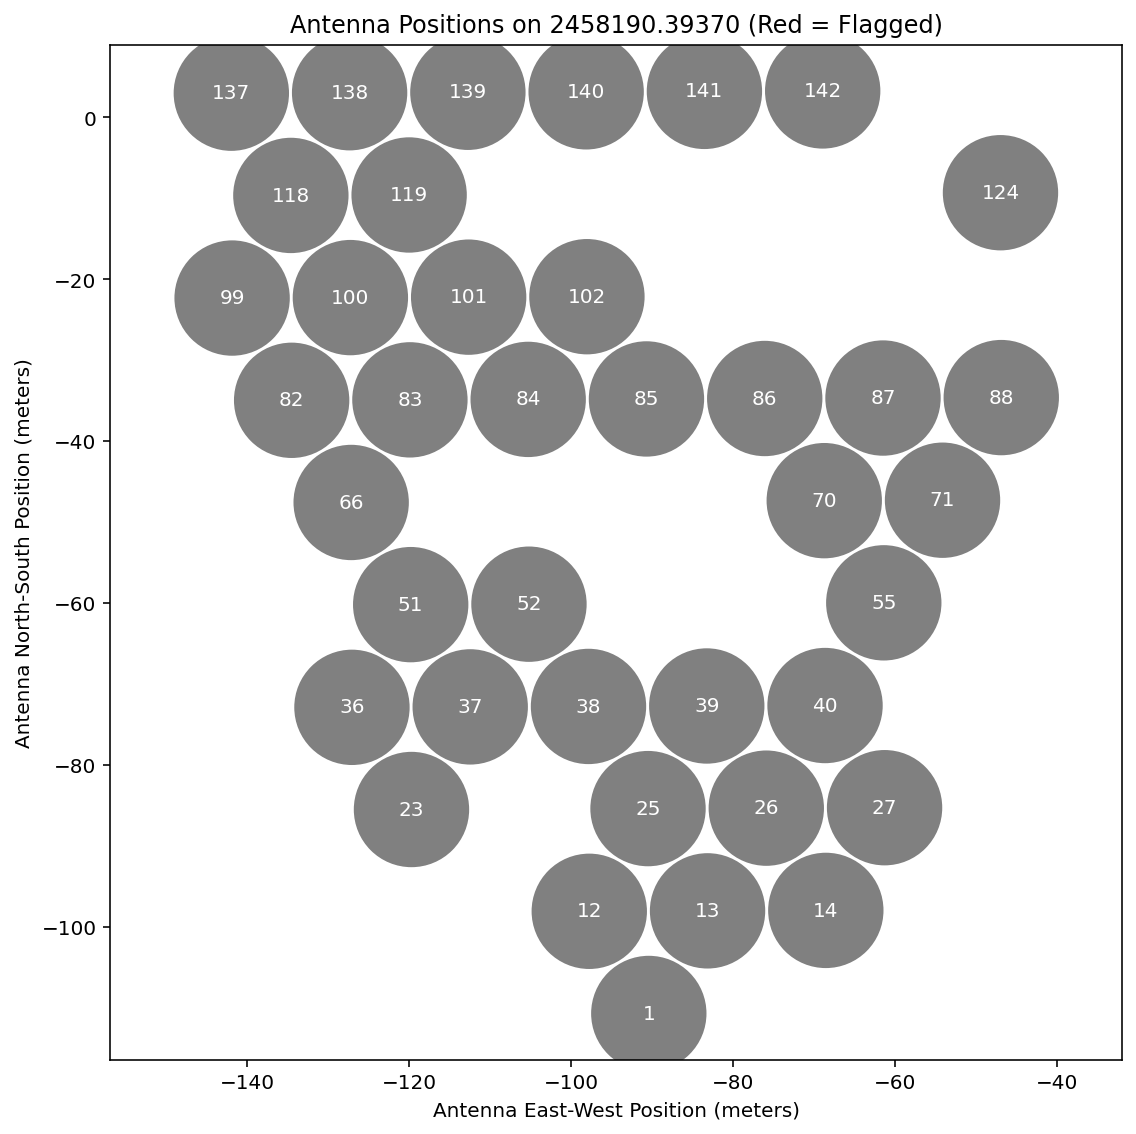

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(np.array([hd.antpos[ant][0] for ant in hd.data_ants]), 
            np.array([hd.antpos[ant][1] for ant in hd.data_ants]), c='w', s=0)
for ant in hd.data_ants:
    pos = hd.antpos[ant]
    bad = ant in [ant[0] for ant in ex_ants]
    plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                    fill=(~bad), color=['grey','r'][bad]))
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
plt.xlabel("Antenna East-West Position (meters)")
plt.ylabel("Antenna North-South Position (meters)")
plt.title('Antenna Positions on {} (Red = Flagged)'.format(file_JD));
plt.axis('equal')
plt.tight_layout()
plt.show()

### Figure 1: Array and Flagged Antennas

#### OBSERVER CHECKLIST:
* Check that the array configuration looks reasonable.
* Check that all flags expected to be flagged are actually flagged but also that not everything is getting flagged.

In [9]:
#check whether the model is redudnant by looking at the history 
model_is_redundant = ('--model_is_redundant' in "".join(hc.history.split()))

# Find files that overlap with this file
abscal_matched_files = list(abscal.match_times(data_list[file_index], 
                                               sorted(glob.glob(abscal_model_glob)), 
                                               filetype='uvh5', atol=1e-5))
hdm = io.HERAData(abscal_matched_files)

# Get model times to load
all_data_times, all_data_lsts = abscal.get_all_times_and_lsts(hd, unwrap=True)
all_model_times, all_model_lsts = abscal.get_all_times_and_lsts(hdm, unwrap=True)
d2m_time_map = abscal.get_d2m_time_map(all_data_times, all_data_lsts, all_model_times, all_model_lsts)
model_times_to_load = [d2m_time_map[time] for time in hd.times]

# Get model baselines to load
model_bls = hdm.bls
model_antpos = hdm.antpos
if isinstance(model_bls, dict):
    model_bls = list(model_bls.values())[0]
    model_antpos = {ant: pos for antpos in hdm.antpos.values() for ant, pos in antpos.items()}
_, model_bl_to_load, data_to_model_bl_map =  abscal.match_baselines(bls_to_plot, model_bls, 
                                                                    hd.antpos, model_antpos=model_antpos, 
                                                                    model_is_redundant=model_is_redundant)
model, model_flags, _ = io.partial_time_io(hdm, times=model_times_to_load, bls=model_bl_to_load)

# Rephase model at index of best match to mean LST in the data
model_blvecs = {bl: model.antpos[bl[0]] - model.antpos[bl[1]] for bl in model.keys()}
utils.lst_rephase(model, model_blvecs, model.freqs, data.lsts - model.lsts,
                  lat=hdm.telescope_location_lat_lon_alt_degrees[0], inplace=True)
if not model_is_redundant:
    model, _, _ = utils.red_average(model, flags=model_flags)

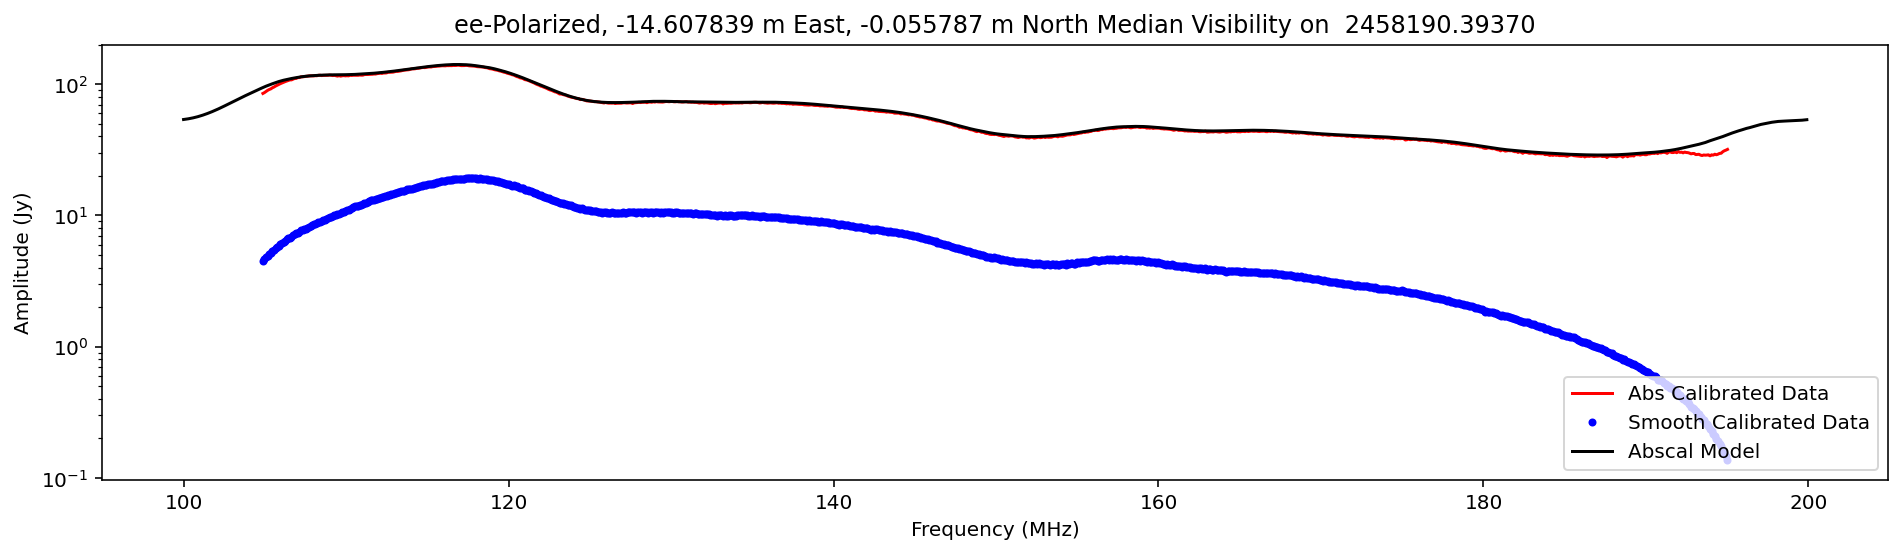

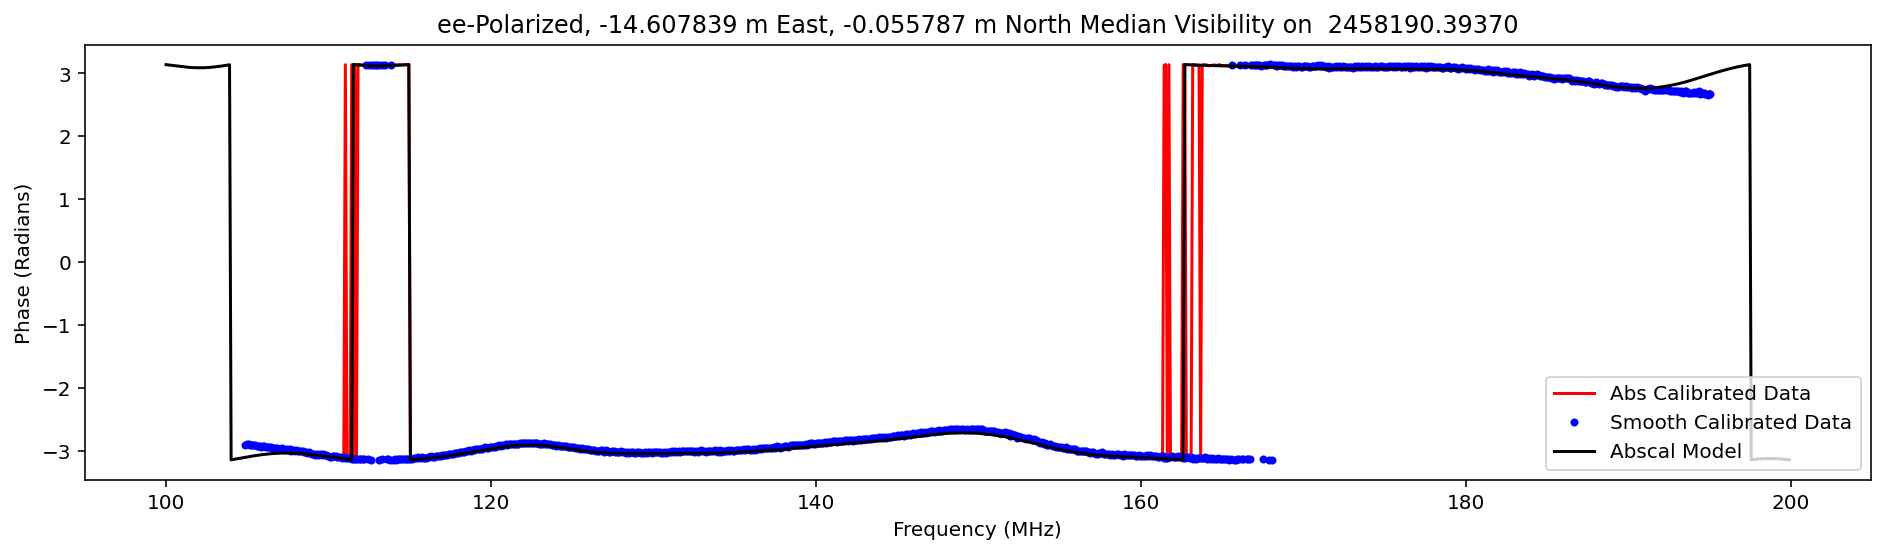

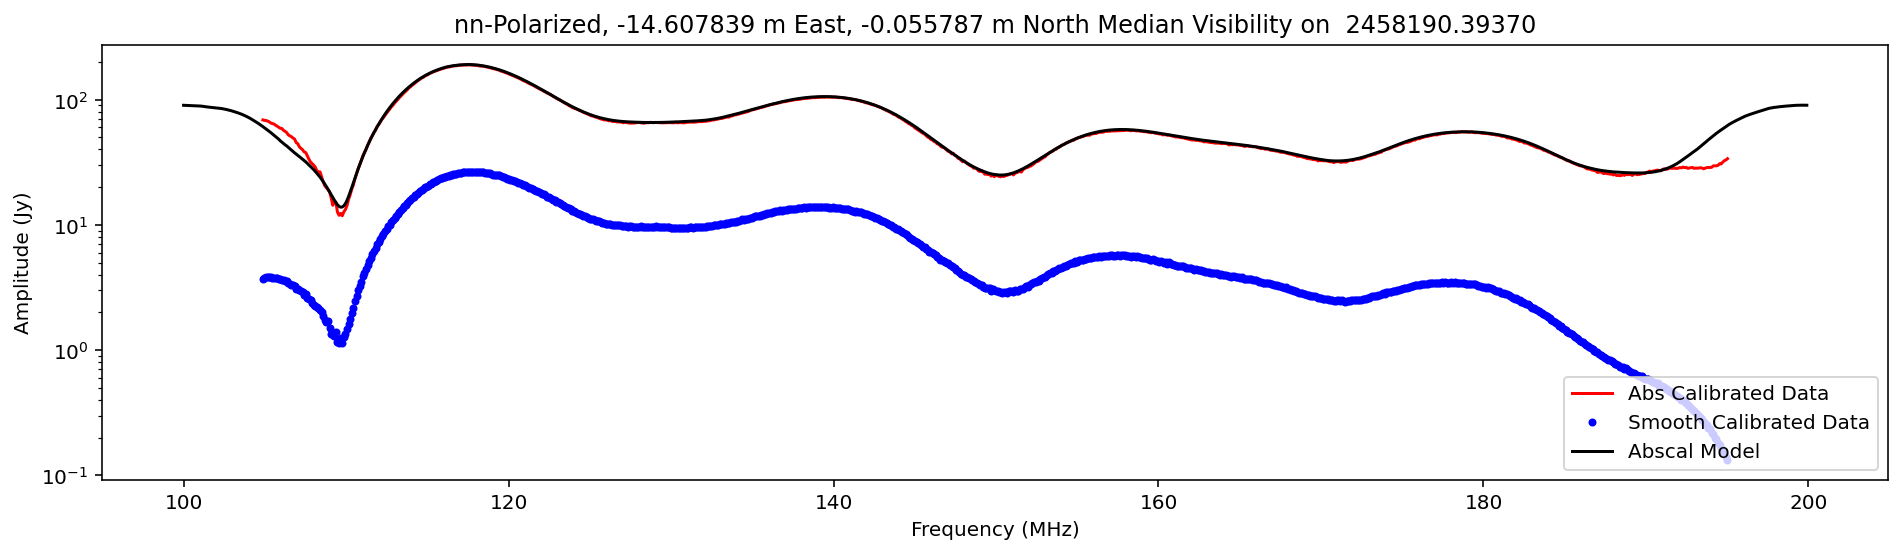

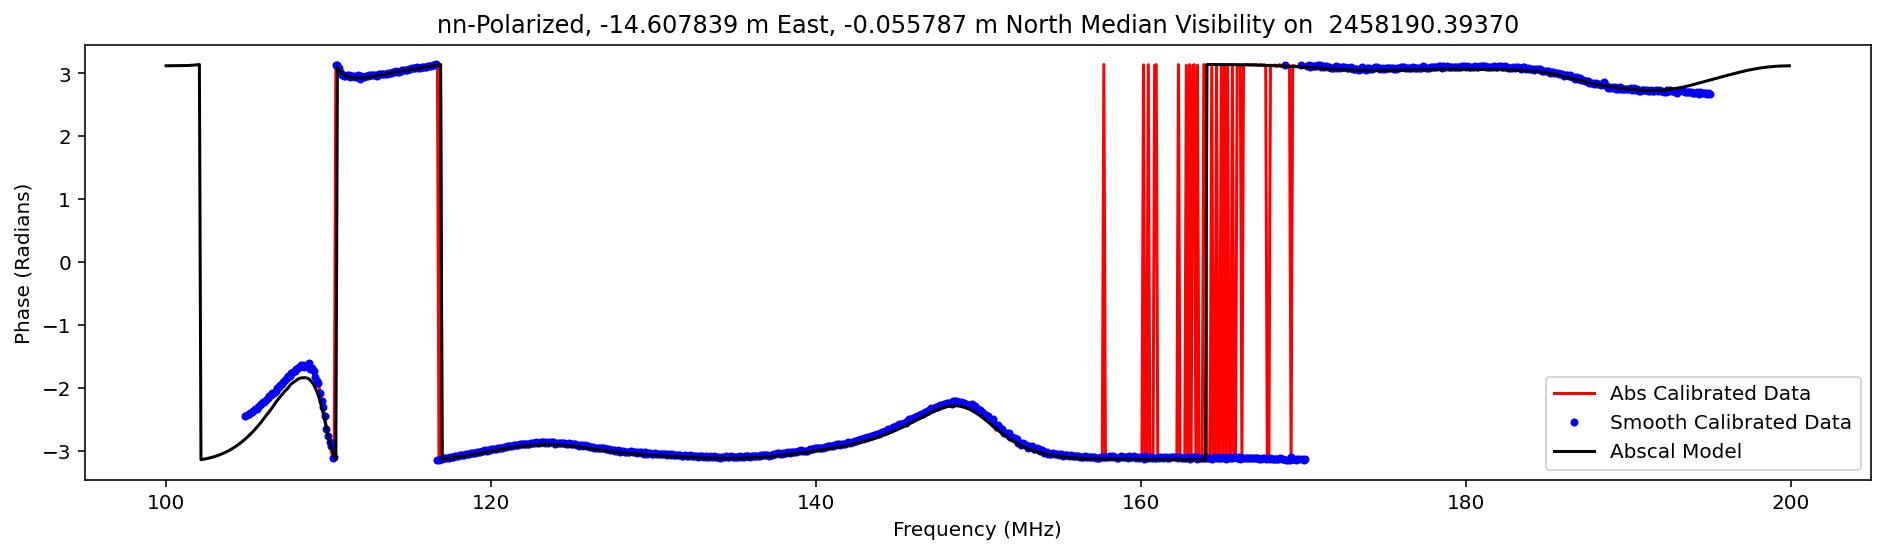

In [10]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for pol in ['ee', 'nn']:
        for func, plot, ylabel in zip([np.abs, np.angle], [plt.semilogy, plt.plot], ['Amplitude (Jy)', 'Phase (Radians)']):
            plt.figure(figsize=(16,4))        
            
            for d, f, l, m in zip([ac_data, sc_data], 
                                  [ac_flags, ac_flags], 
                                  ['Abs Calibrated Data', 'Smooth Calibrated Data'],
                                  ['r-', 'b.']):
                to_avg = []
                for bl in [k for k in bls_to_plot if k[2] == pol]:
                    blvec = hd.antpos[bl[0]] - hd.antpos[bl[1]]
                    to_avg.append(deepcopy(d[bl]))
                    to_avg[-1][f[bl]] = np.nan + 1.0j * np.nan
                to_plot = np.nanmedian(np.real(to_avg), axis=(0,1)) + 1.0j * np.nanmedian(np.imag(to_avg), axis=(0,1))
                plot(hd.freqs/1e6, func(to_plot), m, label=l)

            for bl in [k for k in model if k[2] == pol]:
                to_plot = np.nanmedian(np.real(model[bl]), axis=0) + 1.0j * np.nanmedian(np.imag(model[bl]), axis=0)
                plot(hd.freqs/1e6, func(to_plot), 'k-', label='Abscal Model')
            plt.xlabel('Frequency (MHz)')
            plt.ylabel(ylabel)
            plt.legend(loc='lower right')
            plt.title('{}-Polarized, {:f} m East, {:f} m North Median Visibility on  {}'.format(pol, blvec[0], blvec[1], file_JD))

### Figure 2: Example redundant baseline average, both absolute calibrated and smoothed, compared to the Abscal Model


#### OBSERVER CHECKLIST:
* Check that the abscaled data and the smoothcaled data are reasonably consistent
* Check that both match the abscal model fairly well.

# Load a whole day

In [11]:
# Load relative difference and flagging info from smooth_cal gains
ant_flags_dict = {}
avg_rel_diff_ee_dict = {}
avg_rel_diff_nn_dict = {}
rel_diff_med_dict = {}
ants = set([])

for cal in smooth_cal_list:
    hc = io.HERACal(cal)
    _, flags, rel_diff, avg_rel_diff = hc.read()
    
    ants |= set(flags.keys())
    ant_flags_dict[cal] = {ant: np.all(flags[ant]) for ant in flags}
    avg_rel_diff_ee_dict[cal] = avg_rel_diff['Jee']
    avg_rel_diff_nn_dict[cal] = avg_rel_diff['Jnn']
    rel_diff_med_dict[cal] = {ant: np.nanmedian(rel_diff[ant], axis=1) for ant in rel_diff}    

all_flagged_dict = {ant: np.all([af[ant] for af in ant_flags_dict.values()]) for ant in ants}
avg_rel_diff_ee = np.vstack(np.array(list(avg_rel_diff_ee_dict.values())))
avg_rel_diff_nn = np.vstack(np.array(list(avg_rel_diff_nn_dict.values())))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
# save middle-numbered ants with a minimal number of flags
ants_to_save = {}
ant_to_nflags_dict = {ant: np.sum([af[ant] for af in ant_flags_dict.values()]) for ant in ants}
for pol in ['Jee', 'Jnn']:
    min_flags = np.min([ant_to_nflags_dict[ant] for ant in ants if ant[1] == pol])
    ant_candidates = sorted([ant for ant in ants if ant_to_nflags_dict[ant] == min_flags and ant[1] == pol])
    Nac = len(ant_candidates)
    ants_to_save[pol] = ant_candidates[(Nac // 2 - 1):(Nac // 2 + 1)]

In [13]:
# Load smooth_cal gains/flags
times_dict = {}
sc_gain_dict = {}
sc_flag_dict = {}
for cal in smooth_cal_list:
    hc = io.HERACal(cal)
    gains, flags, _, _ = hc.read()
    times_dict[cal] = hc.times
    sc_gain_dict[cal] = {ant: gains[ant] for pol in ants_to_save for ant in ants_to_save[pol]}
    sc_flag_dict[cal] = {ant: flags[ant] for pol in ants_to_save for ant in ants_to_save[pol]}

# Load abscal gains/flags
ac_gain_dict = {}
ac_flag_dict = {}
for cal in abscal_list:
    hc = io.HERACal(cal)
    gains, flags, _, _ = hc.read()
    ac_gain_dict[cal] = {ant: gains[ant] for pol in ants_to_save for ant in ants_to_save[pol]}
    ac_flag_dict[cal] = {ant: flags[ant] for pol in ants_to_save for ant in ants_to_save[pol]}    

# Organize gains/flags into grids
times = np.hstack(list(times_dict.values()))
lsts = 12 / np.pi * pyuvdata.utils.get_lst_for_time(times, *hd.telescope_location_lat_lon_alt_degrees)
sc_gains = {ant: np.vstack([sc_gain_dict[cal][ant] for cal in sc_gain_dict]) 
                 for pol in ants_to_save for ant in ants_to_save[pol]}    
sc_flags = {ant: np.vstack([sc_flag_dict[cal][ant] for cal in sc_flag_dict]) 
                 for pol in ants_to_save for ant in ants_to_save[pol]}    
flag_mask = np.all([f for f in sc_flags.values()], axis=0)
ac_gains = {ant: np.vstack([ac_gain_dict[cal][ant] for cal in ac_gain_dict]) 
                 for pol in ants_to_save for ant in ants_to_save[pol]}
ac_flags = {ant: np.vstack([ac_flag_dict[cal][ant] for cal in ac_flag_dict]) 
                 for pol in ants_to_save for ant in ants_to_save[pol]}

# Inspect a whole day

In [14]:
# for overplotting blacklisted LSTs
my_cmap = cm.binary
my_cmap.set_under('k', alpha=0)
blacklist = np.ones_like(avg_rel_diff_ee) * np.hstack(time_blacklisted)[:, np.newaxis]

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("binary").copy()


divide by zero encountered in true_divide
FixedFormatter should only be used together with FixedLocator
All-NaN slice encountered
All-NaN slice encountered
All-NaN slice encountered
All-NaN slice encountered
divide by zero encountered in true_divide
FixedFormatter should only be used together with FixedLocator


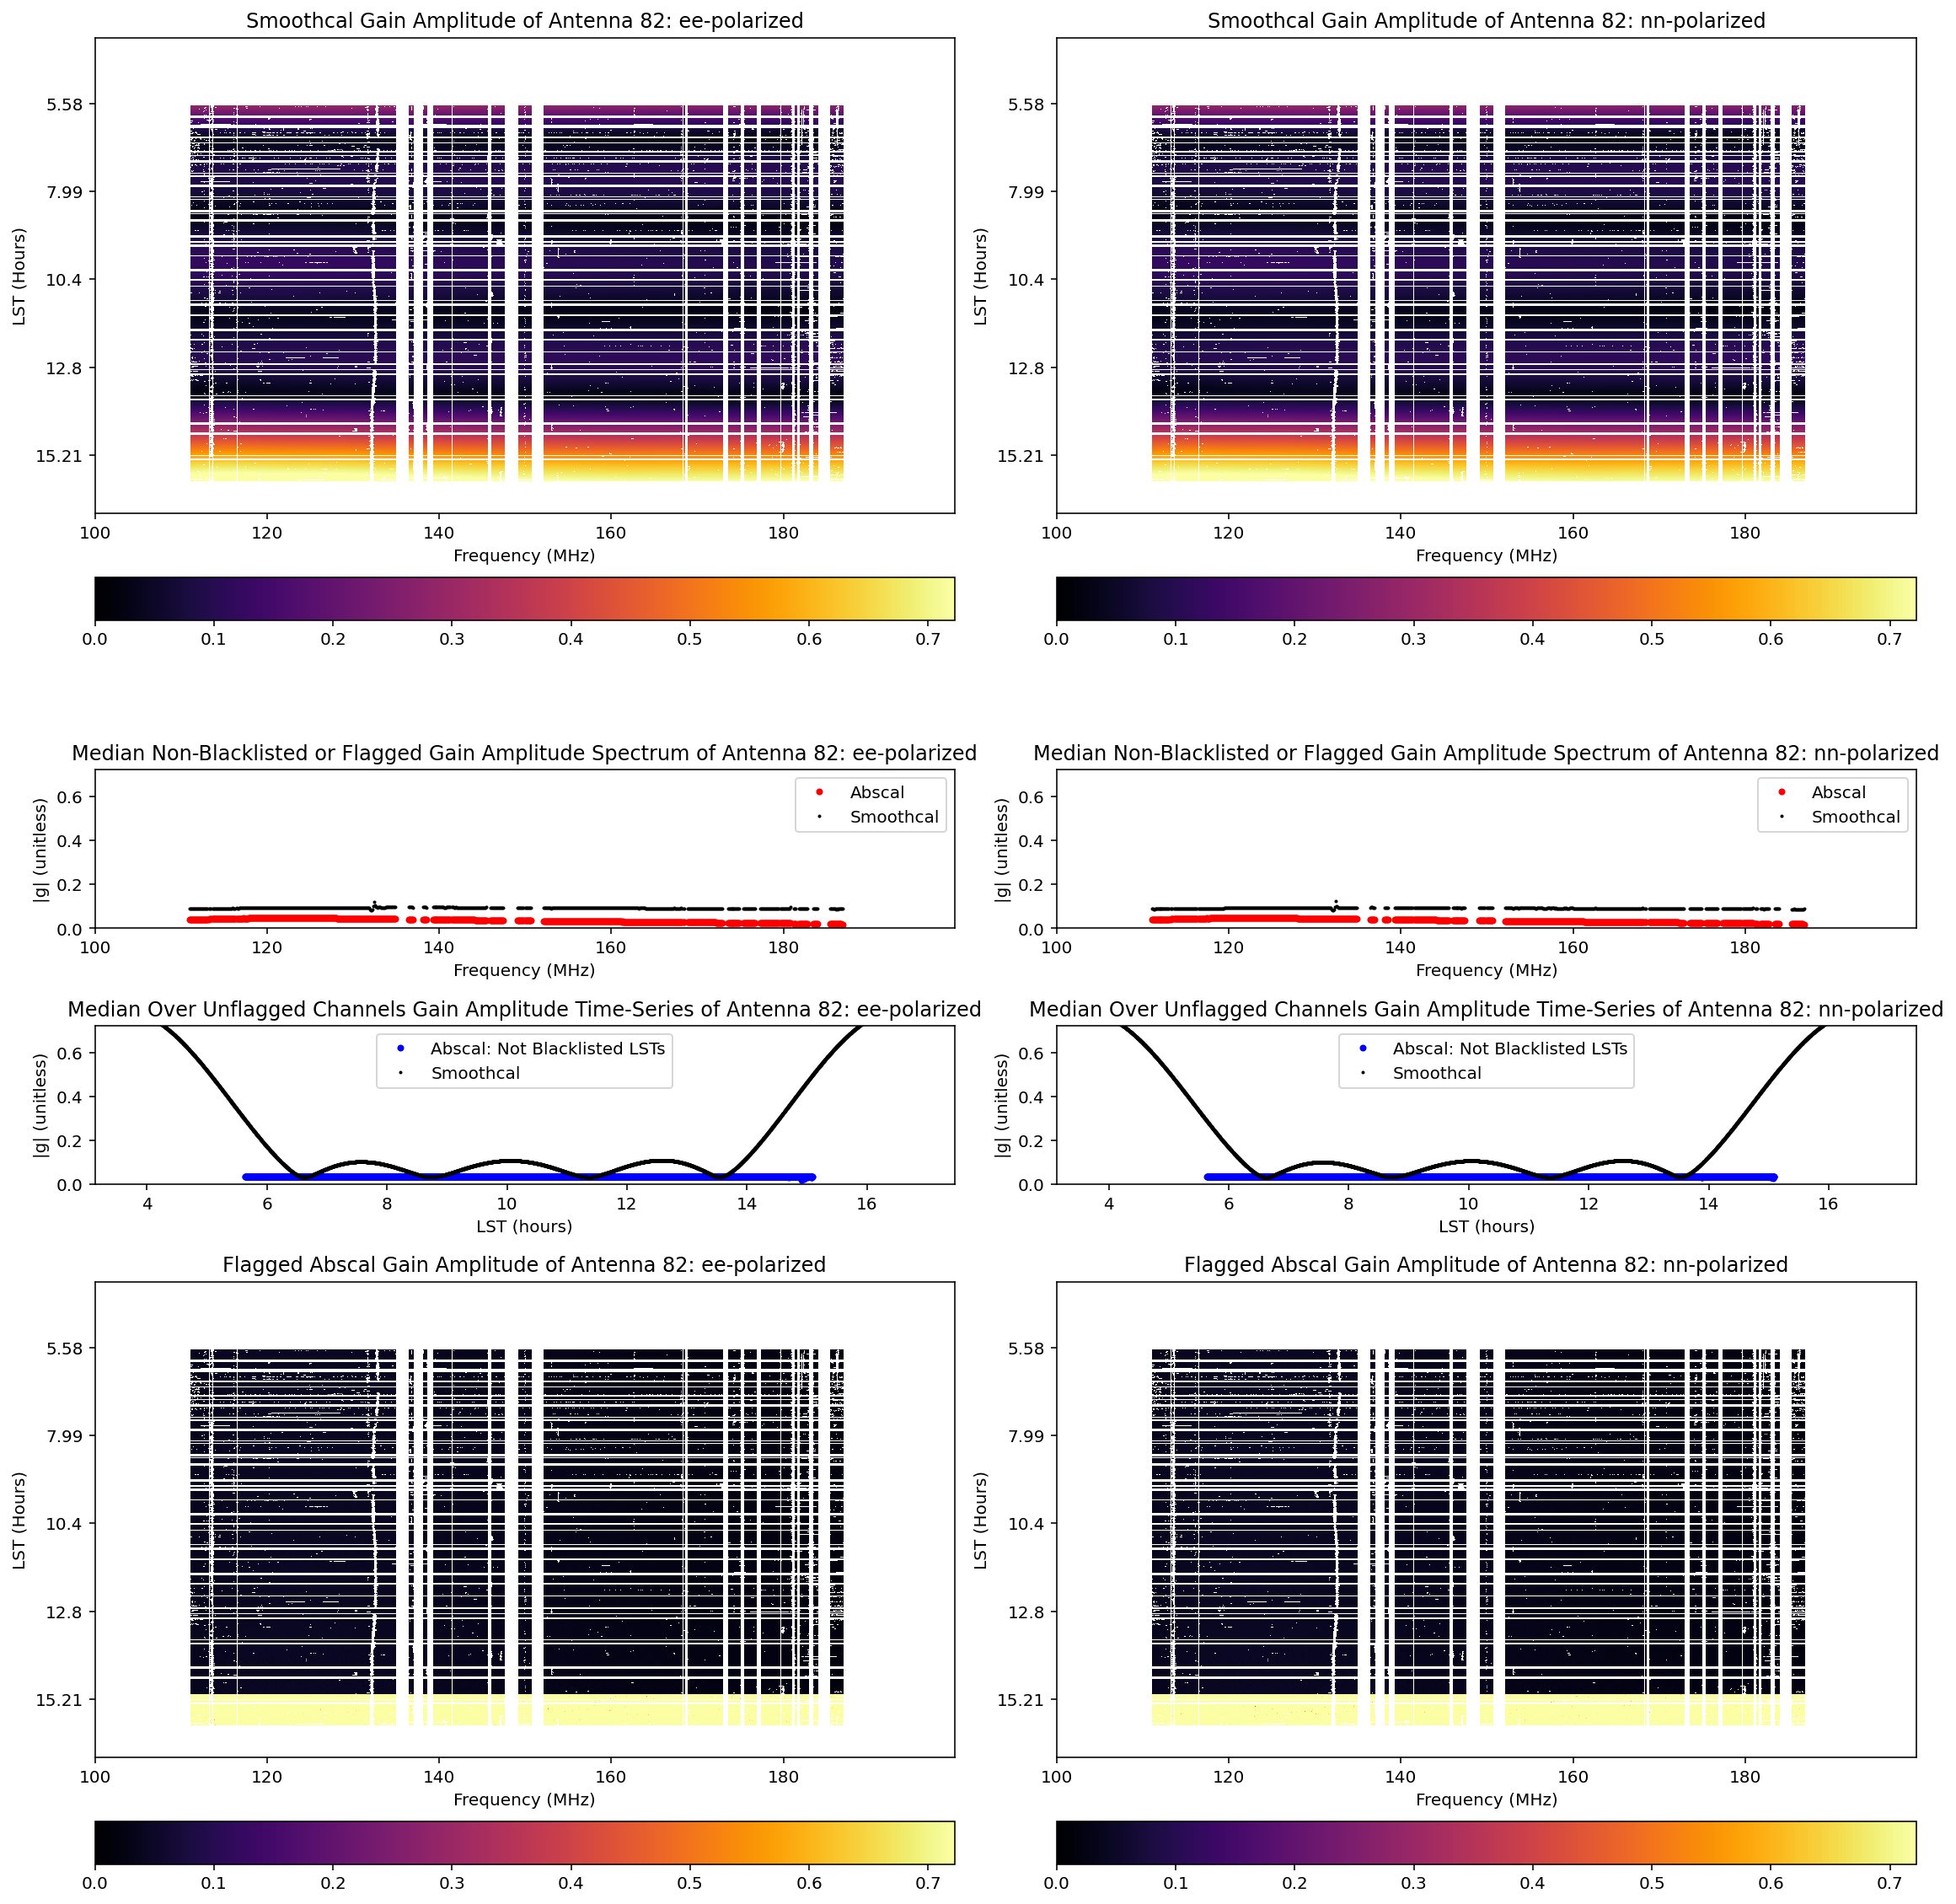

In [15]:
# Pick vmax to not saturate 90% of the abscal gains
vmax = np.max([np.percentile(np.abs(sc_gains[ants_to_save[pol][1]][~flag_mask]), 99) for pol in ['Jee', 'Jnn']])

# Plot abscal gain amplitude waterfalls for a single antenna
fig, axes = plt.subplots(4, 2, figsize=(16,16), gridspec_kw={'height_ratios': [1, .25, .25, 1]})
for ax, pol in zip(axes[0], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(np.abs(sc_gains[ant]) / ~sc_flags[ant], aspect='auto', cmap='inferno', 
                   interpolation='nearest', vmin=0, vmax=vmax, extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title(f'Smoothcal Gain Amplitude of Antenna {ant[0]}: {pol[1:]}-polarized' )
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')
    ax.set_xlim([hd.freqs[0]/1e6, hd.freqs[-1]/1e6])
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))    
    plt.colorbar(im, ax=ax,  orientation='horizontal', pad=.1)

# Now plot median gain spectra 
for ax, pol in zip(axes[1], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    # plot abscal
    to_med = deepcopy(np.abs(ac_gains[ant]))
    to_med[sc_flags[ant]] = np.nan  
    if not np.all(np.hstack(time_blacklisted)):
        ax.plot(hd.freqs / 1e6, np.nanmedian(to_med[~np.hstack(time_blacklisted), :], axis=0), 'r.', label='Abscal')    

    # plot smooth_cal
    to_med = deepcopy(np.abs(sc_gains[ant]))
    to_med[sc_flags[ant]] = np.nan  
    if not np.all(np.hstack(time_blacklisted)):
        ax.plot(hd.freqs / 1e6, np.nanmedian(to_med[~np.hstack(time_blacklisted), :], axis=0), 'k.', ms=2, label='Smoothcal')
    
    ax.set_ylim([0, vmax])
    ax.set_xlim([hd.freqs[0]/1e6, hd.freqs[-1]/1e6])    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('|g| (unitless)')
    ax.set_title(f'Median Non-Blacklisted or Flagged Gain Amplitude Spectrum of Antenna {ant[0]}: {pol[1:]}-polarized')
    ax.legend()

# Now plot median gain time series
for ax, pol in zip(axes[2], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    to_med = deepcopy(np.abs(ac_gains[ant]))
    to_med[:, np.all(sc_flags[ant], axis=0)] = np.nan  
    # plot abscal
    if not np.all(np.hstack(time_blacklisted)):
        ax.plot(lsts[~np.hstack(time_blacklisted)], 
                np.nanmedian(to_med[~np.hstack(time_blacklisted), :], axis=1), 
                'b.', label='Abscal: Not Blacklisted LSTs')
    if np.any(np.hstack(time_blacklisted)):
        ax.plot(lsts[np.hstack(time_blacklisted)], 
                np.nanmedian(to_med[np.hstack(time_blacklisted), :], axis=1), 
                'r.', label='Abscal: Blacklisted LSTs')

    # plot smooth_cal
    to_med = deepcopy(np.abs(sc_gains[ant]))
    to_med[:, np.all(sc_flags[ant], axis=0)] = np.nan
    ax.plot(lsts, np.nanmedian(to_med, axis=1),'k.', ms=2, label='Smoothcal')    
        
    ax.set_ylim([0, vmax])
    ax.set_xlabel('LST (hours)')
    ax.set_ylabel('|g| (unitless)')
    ax.set_title(f'Median Over Unflagged Channels Gain Amplitude Time-Series of Antenna {ant[0]}: {pol[1:]}-polarized')
    ax.legend()
    
# Now flagged plot abscal waterfall    
for ax, pol in zip(axes[3], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(np.abs(ac_gains[ant]) / ~sc_flags[ant], aspect='auto', cmap='inferno', 
                   interpolation='nearest', vmin=0, vmax=vmax, extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title(f'Flagged Abscal Gain Amplitude of Antenna {ant[0]}: {pol[1:]}-polarized' )
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')
    ax.set_xlim([hd.freqs[0]/1e6, hd.freqs[-1]/1e6])
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))    
    plt.colorbar(im, ax=ax,  orientation='horizontal', pad=.1)    

plt.tight_layout()

### Figure 3 Example Smoothing of Gain Amplitudes
Smoothcal (top row) and Abscal (bottom row) gain amplitudes for an example antenna. In the waterfalls, grayed out regions are "blacklisted," meaning they are not flagged but they are given zero weight when performing calibration smoothing. We also plot median non-blacklisted amplitudes as a function of frequency (second row) and the median amplitude as a function of time (third row) for both abscal and smoothcal.

#### OBSERVER CHECKLIST:
* Check that the smoothcal solution matches the abscal solution reasonably well in the non-blacklisted regions.
* Check to see that the overall bandpass looks reasonable

divide by zero encountered in true_divide
FixedFormatter should only be used together with FixedLocator
All-NaN slice encountered
All-NaN slice encountered
All-NaN slice encountered
All-NaN slice encountered
divide by zero encountered in true_divide
invalid value encountered in true_divide
FixedFormatter should only be used together with FixedLocator


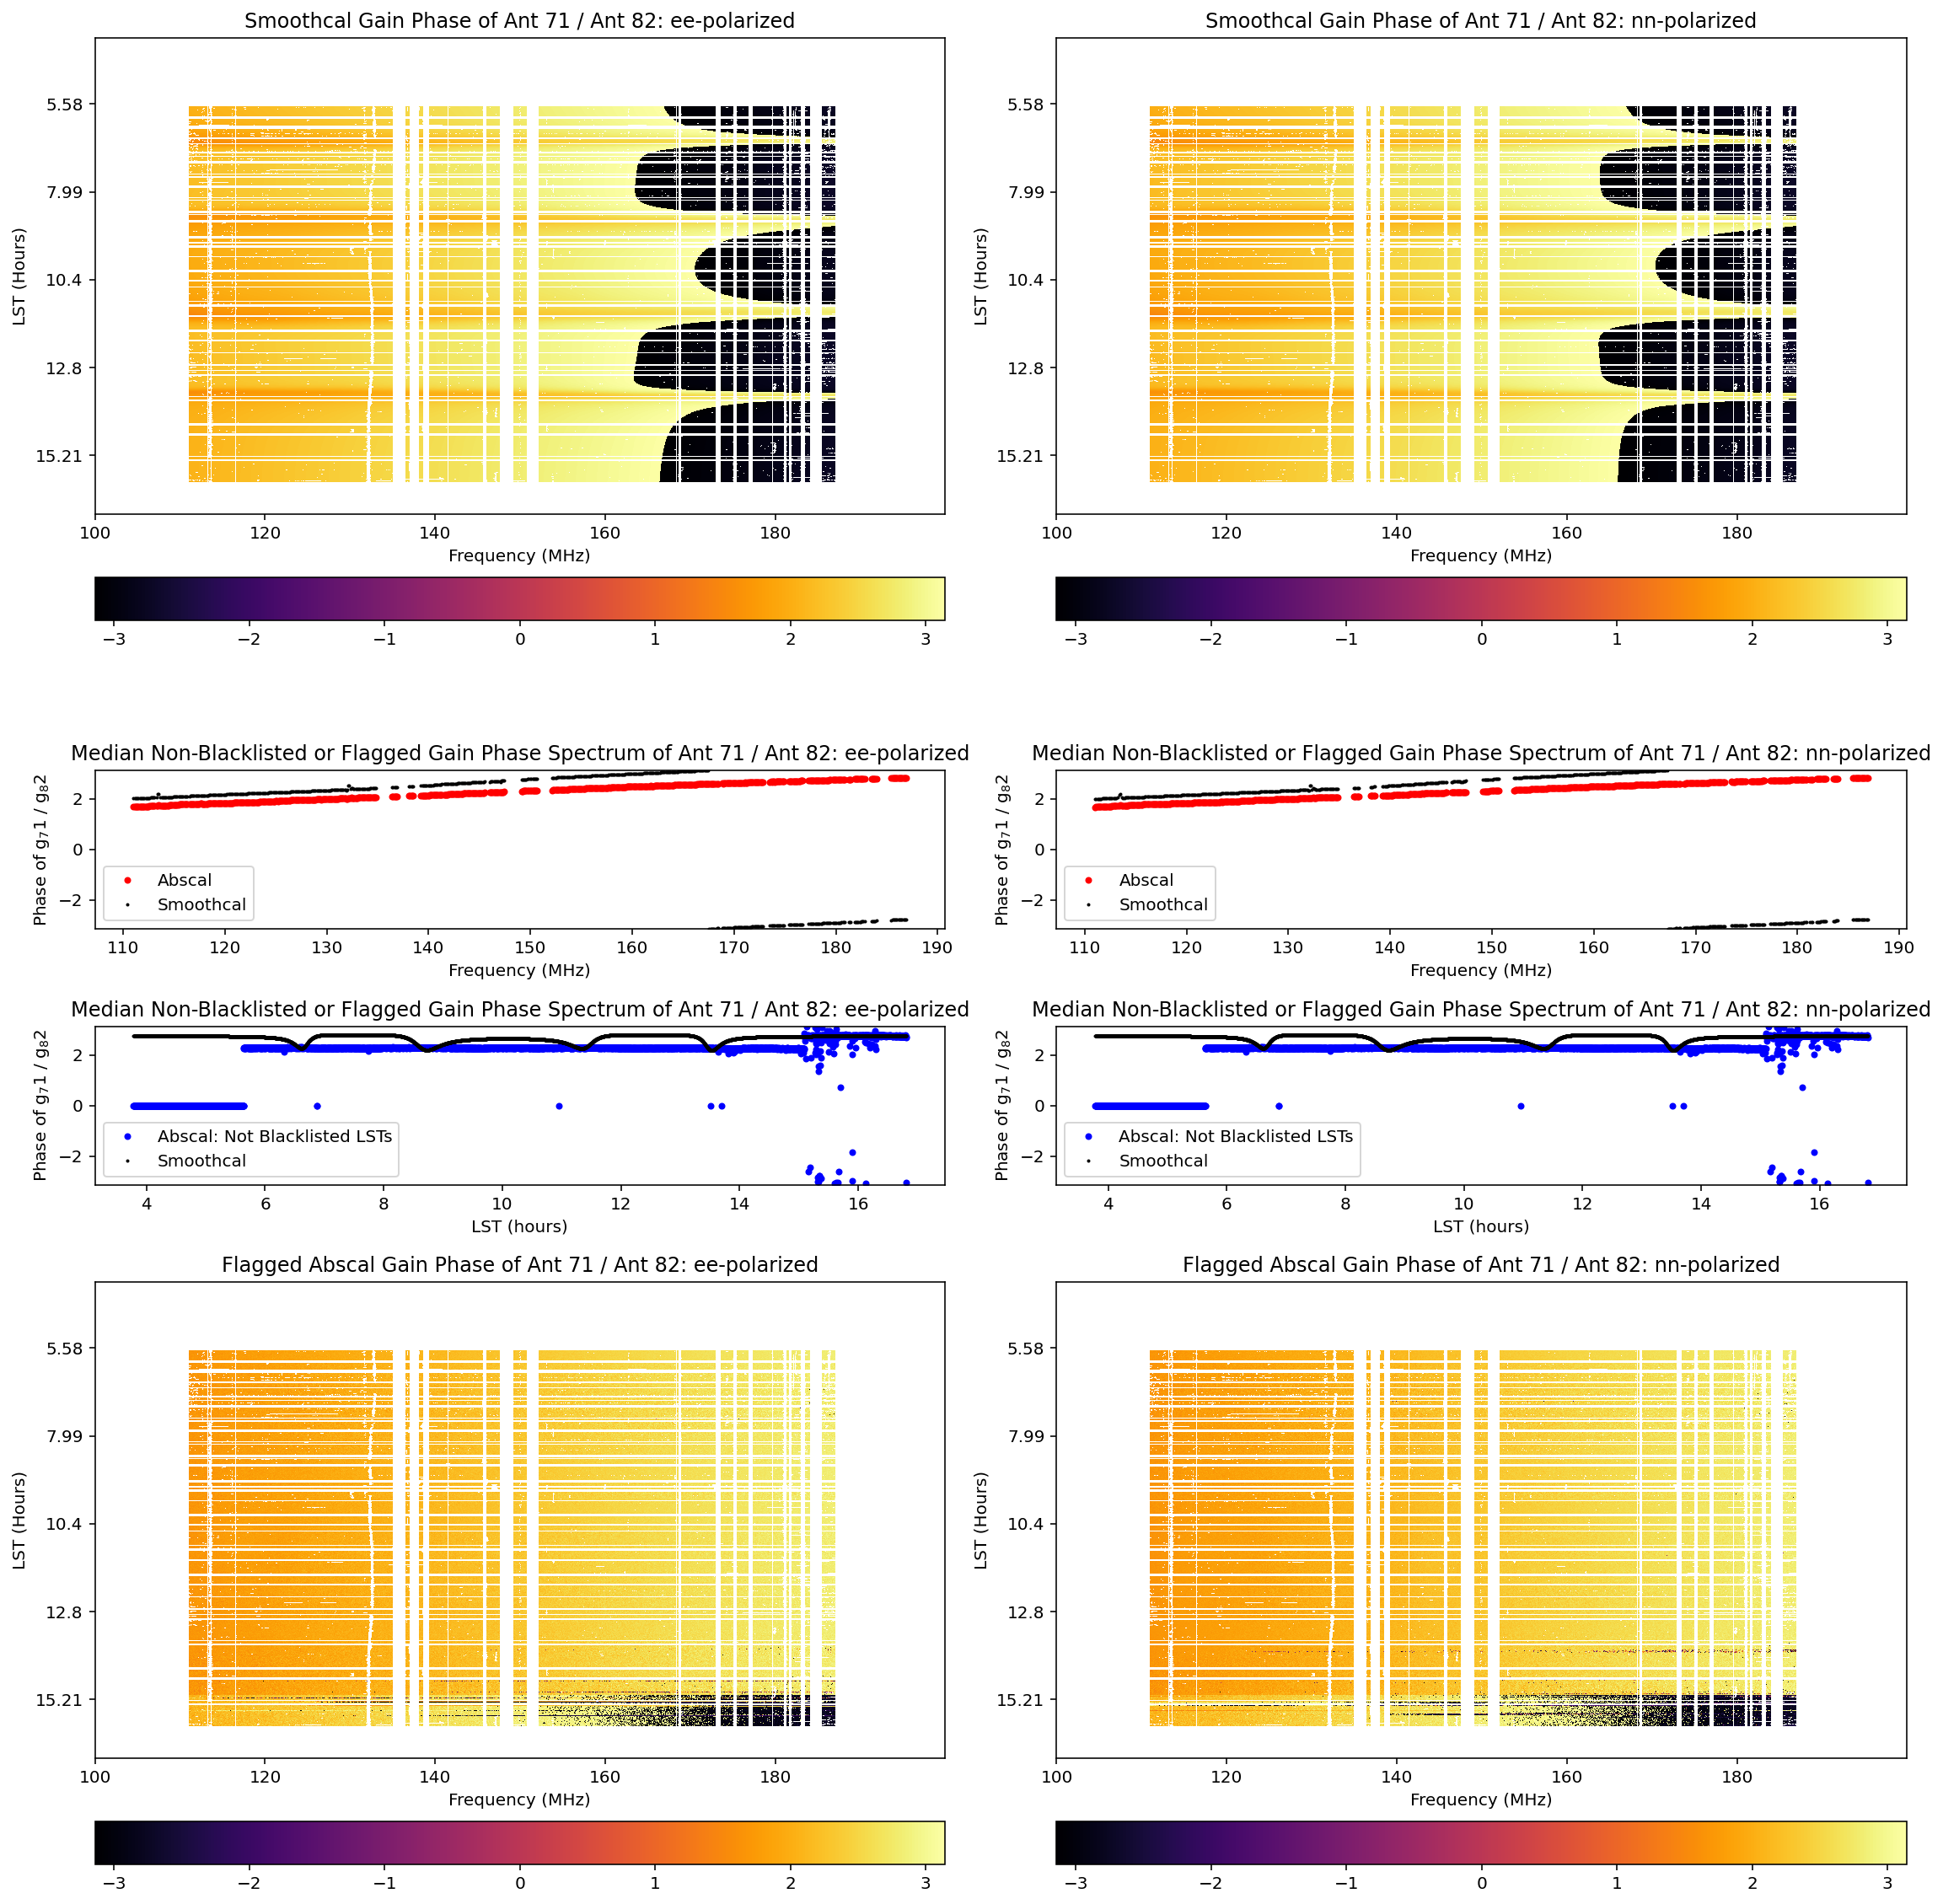

In [16]:
# Plot abscal gain amplitude waterfalls for a single antenna
fig, axes = plt.subplots(4, 2, figsize=(16,16), gridspec_kw={'height_ratios': [1, .25, .25, 1]})
for ax, pol in zip(axes[0], ['Jee', 'Jnn']):
    ant0, ant1 = ants_to_save[pol]
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(np.angle(sc_gains[ant0] / sc_gains[ant1]) / ~sc_flags[ant0], aspect='auto', cmap='inferno', 
                   interpolation='nearest', vmin=-np.pi, vmax=np.pi, extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title(f'Smoothcal Gain Phase of Ant {ant0[0]} / Ant {ant1[0]}: {pol[1:]}-polarized')    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')
    ax.set_xlim([hd.freqs[0]/1e6, hd.freqs[-1]/1e6])
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))
    plt.colorbar(im, ax=ax,  orientation='horizontal', pad=.1)

# Now plot median gain spectra 
for ax, pol in zip(axes[1], ['Jee', 'Jnn']):
    ant0, ant1 = ants_to_save[pol]
    
    # plot abscal
    to_med = deepcopy(ac_gains[ant0] / ac_gains[ant1])
    to_med[sc_flags[ant0]] = np.nan + 1.0j * np.nan
    if not np.all(np.hstack(time_blacklisted)):
        med = 1.0j * np.nanmedian(to_med[~np.hstack(time_blacklisted), :].imag, axis=0)
        med += np.nanmedian(to_med[~np.hstack(time_blacklisted), :].real, axis=0) 
        ax.plot(hd.freqs / 1e6, np.angle(med), 'r.', label='Abscal')

    # plot smooth_cal
    to_med = deepcopy(sc_gains[ant0] / sc_gains[ant1])
    to_med[sc_flags[ant0]] = np.nan + 1.0j * np.nan
    if not np.all(np.hstack(time_blacklisted)):
        med = 1.0j * np.nanmedian(to_med[~np.hstack(time_blacklisted), :].imag, axis=0)
        med += np.nanmedian(to_med[~np.hstack(time_blacklisted), :].real, axis=0) 
        ax.plot(hd.freqs / 1e6, np.angle(med), 'k.', ms=2, label='Smoothcal')

    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel(f'Phase of g$_{ant0[0]}$ / g$_{ant1[0]}$')
    ax.set_title(f'Median Non-Blacklisted or Flagged Gain Phase Spectrum of Ant {ant0[0]} / Ant {ant1[0]}: {pol[1:]}-polarized')
    ax.legend()

# Now plot median gain time series
for ax, pol in zip(axes[2], ['Jee', 'Jnn']):
    ant = ants_to_save[pol][1]
    to_med = deepcopy(np.abs(ac_gains[ant]))
    to_med[:, np.all(sc_flags[ant], axis=0)] = np.nan  
    
    # plot abscal
    to_med = deepcopy(ac_gains[ant0] / ac_gains[ant1])
    to_med[:, np.all(sc_flags[ant], axis=0)] = np.nan + 1.0j * np.nan
    if not np.all(np.hstack(time_blacklisted)):
        med = 1.0j * np.nanmedian(to_med[~np.hstack(time_blacklisted), :].imag, axis=1)
        med += np.nanmedian(to_med[~np.hstack(time_blacklisted), :].real, axis=1) 
        ax.plot(lsts[~np.hstack(time_blacklisted)], np.angle(med), 'b.', label='Abscal: Not Blacklisted LSTs')
        
    if np.any(np.hstack(time_blacklisted)):
        med = 1.0j * np.nanmedian(to_med[np.hstack(time_blacklisted), :].imag, axis=1)
        med += np.nanmedian(to_med[np.hstack(time_blacklisted), :].real, axis=1) 
        ax.plot(lsts[np.hstack(time_blacklisted)], np.angle(med), 'r.', label='Abscal: Blacklisted LSTs')        

    # plot smooth_cal
    to_med = deepcopy(sc_gains[ant0] / sc_gains[ant1])
    to_med[:, np.all(sc_flags[ant], axis=0)] = np.nan + 1.0j * np.nan
    med = 1.0j * np.nanmedian(to_med.imag, axis=1) +  np.nanmedian(to_med.real, axis=1) 
    ax.plot(lsts, np.angle(med), 'k.', ms=2, label='Smoothcal')        
        
    ax.set_ylim([-np.pi, np.pi])
    ax.set_xlabel('LST (hours)')
    ax.set_ylabel(f'Phase of g$_{ant0[0]}$ / g$_{ant1[0]}$')
    ax.set_title(f'Median Non-Blacklisted or Flagged Gain Phase Spectrum of Ant {ant0[0]} / Ant {ant1[0]}: {pol[1:]}-polarized')
    ax.legend()
    
# Now flagged plot abscal waterfall
for ax, pol in zip(axes[3], ['Jee', 'Jnn']):
    ant0, ant1 = ants_to_save[pol]
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(np.angle(ac_gains[ant0] / ac_gains[ant1]) / ~sc_flags[ant], aspect='auto', cmap='inferno', 
                   interpolation='nearest', vmin=-np.pi, vmax=np.pi, extent=extent)
    ax.imshow(blacklist, aspect='auto', cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title(f'Flagged Abscal Gain Phase of Ant {ant0[0]} / Ant {ant1[0]}: {pol[1:]}-polarized')    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')   
    ax.set_xlim([hd.freqs[0]/1e6, hd.freqs[-1]/1e6])    
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))
    plt.colorbar(im, ax=ax,  orientation='horizontal', pad=.1)    

plt.tight_layout()

### Figure 4 Example Smoothing of Gain Phases
Smoothcal (top row) and Abscal (bottom row) gain phases for an example antenna. In the waterfalls, grayed out regions are "blacklisted," meaning they are not flagged but they are given zero weight when performing calibration smoothing. We also plot median non-blacklisted phases as a function of frequency (second row) and the median phases as a function of time (third row) for both abscal and smoothcal.

#### OBSERVER CHECKLIST:
* Check that the smoothcal solution matches the abscal solution reasonably well in the non-blacklisted regions.
* Check to see that the final gain solution is reasonably approximated by a single time-independent delay (linear phase ramp in row 2).

invalid value encountered in true_divide
FixedFormatter should only be used together with FixedLocator


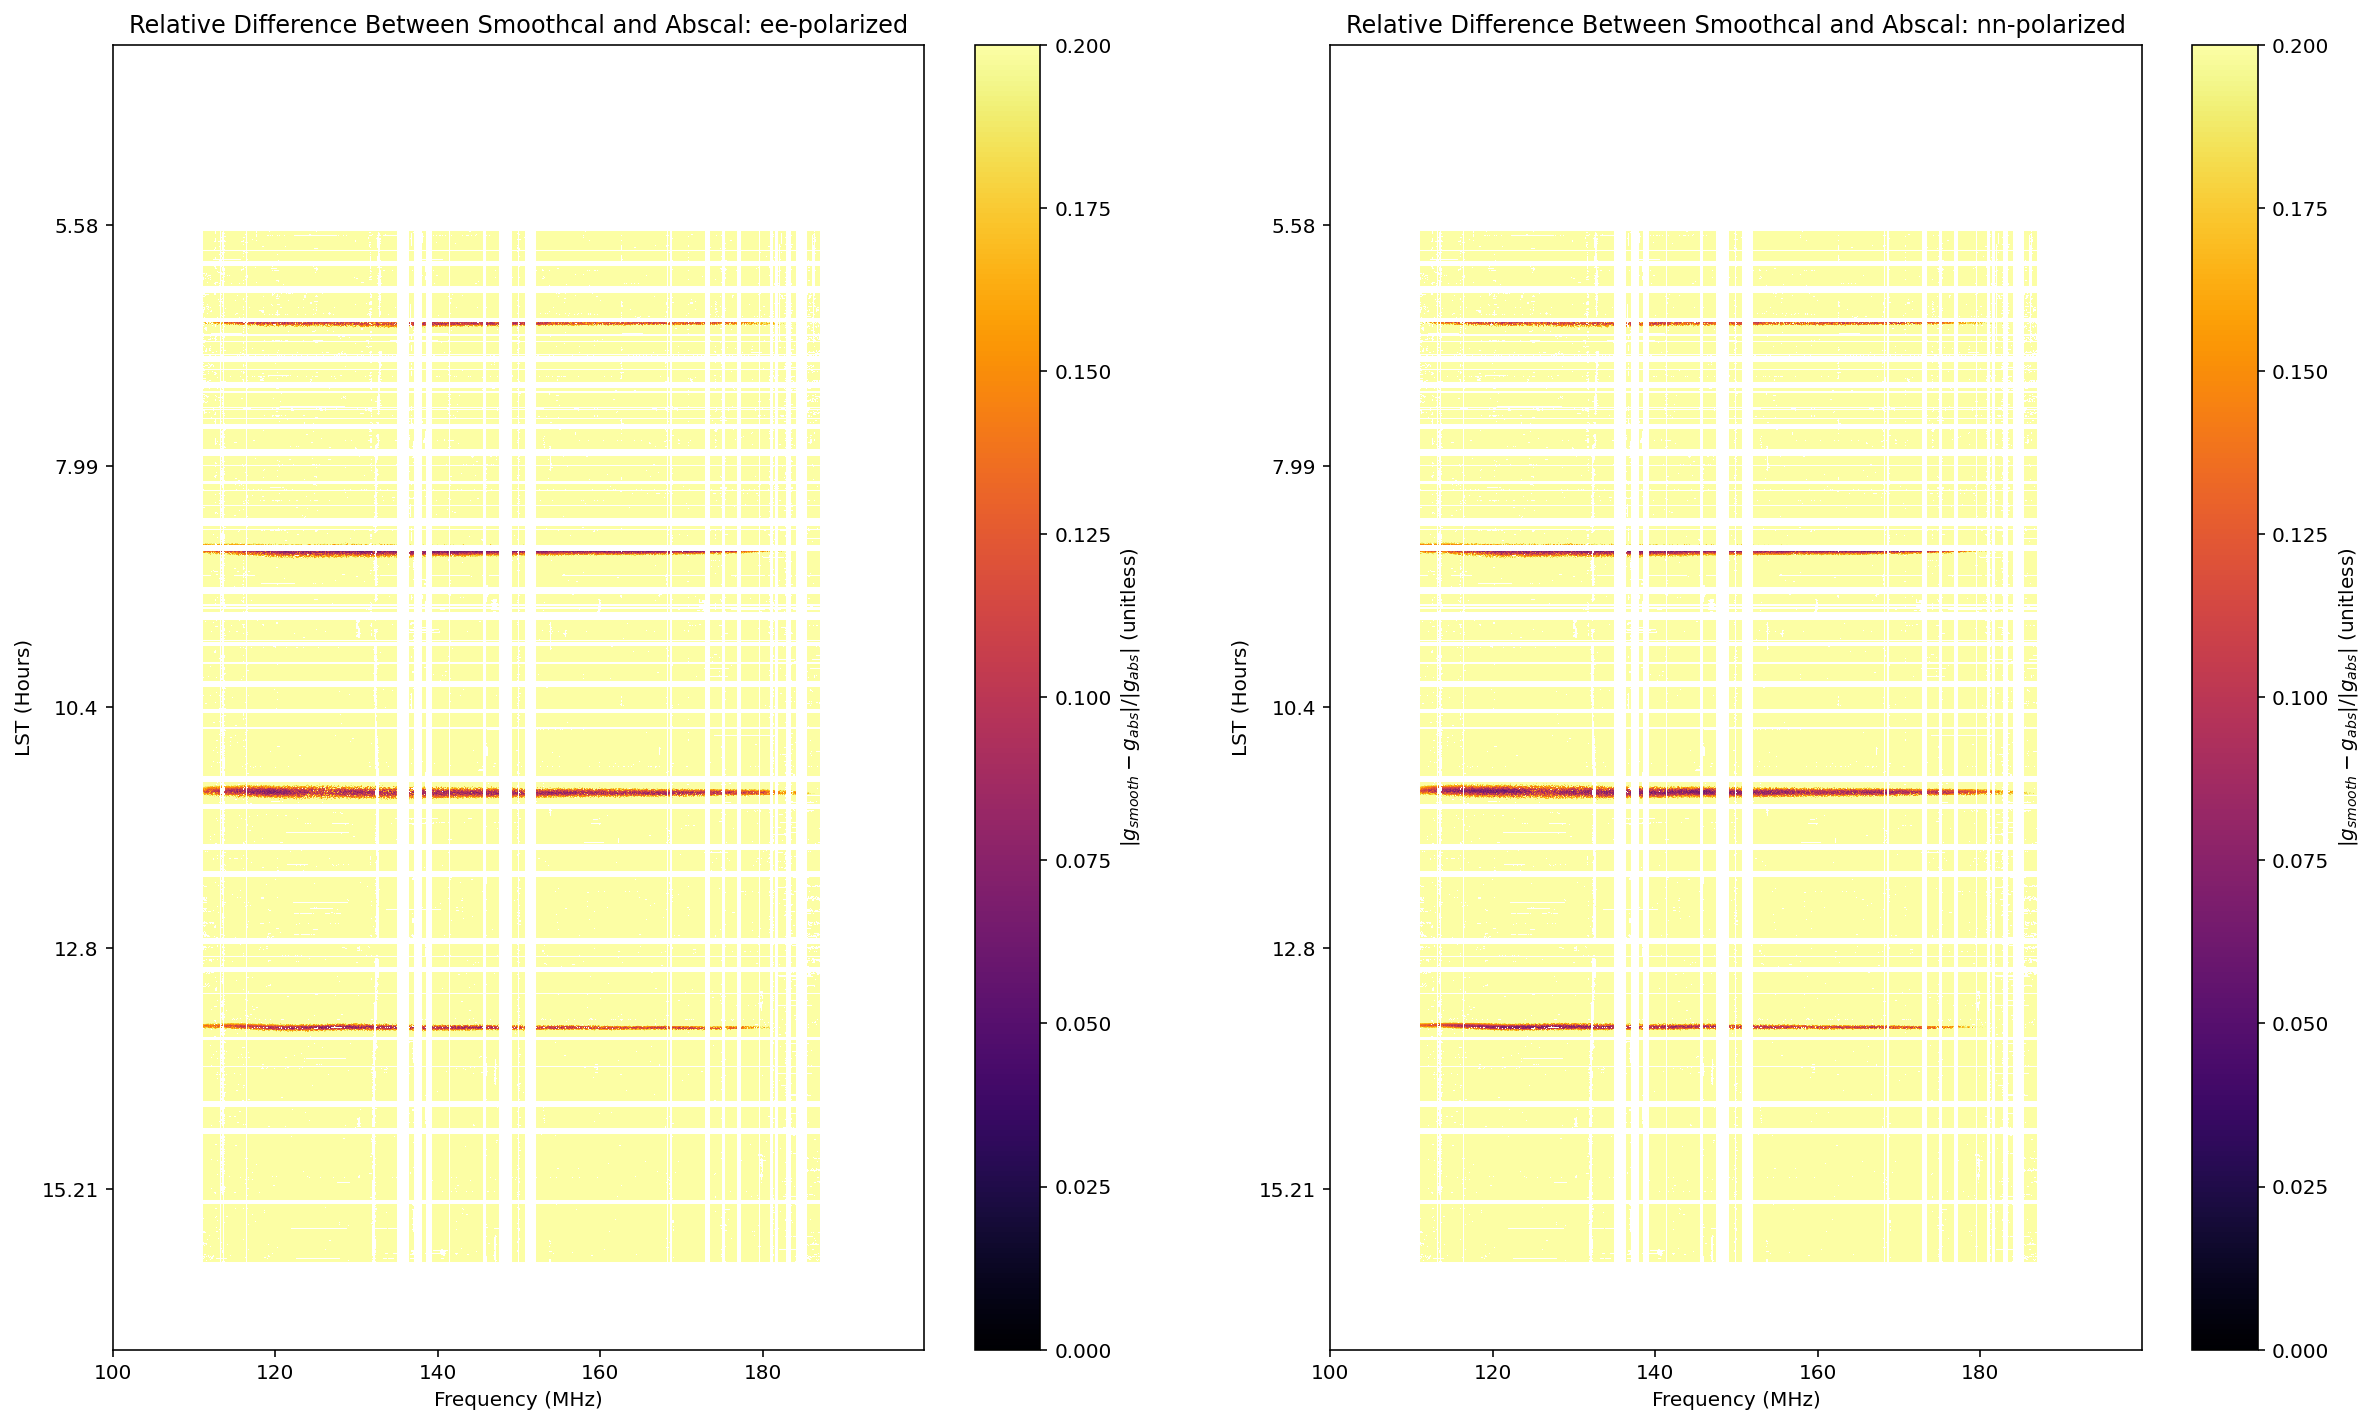

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20,12))
for ax, rd, t in zip(axes, [avg_rel_diff_ee, avg_rel_diff_nn], ['ee-polarized', 'nn-polarized']):
    extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, times[-1], times[0]]
    im = ax.imshow(rd / ~sc_flags[ant0], aspect='auto', vmin=0, cmap='inferno', vmax=.2, interpolation='nearest', extent=extent)
    ax.imshow(blacklist, aspect='auto', 
              cmap=my_cmap, interpolation=None, clim=[0.9, 1], alpha=.25, extent=extent)
    ax.set_title('Relative Difference Between Smoothcal and Abscal: ' + t)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (Hours)')
    ax.set_yticklabels(np.around(lsts[[min(max(np.searchsorted(times, t), 0), len(times) - 1) for t in ax.get_yticks()]], 2))
    plt.colorbar(im, ax=ax, label='$|g_{smooth} - g_{abs}| / |g_{abs}|$ (unitless)')

### Figure 5: Relative difference between Abscal and Smoothcal

Where omnical calfits files store $\chi^2$ per antenna, smooth_cal calfits files store the relative difference between Abscal and Smoothcal gains. This difference is done before taking the absolute value, so this metric is sensitive both to phase errors and amplitude errors.

#### OBSERVER CHECKLIST:
* Look for regions of high relative difference that are not blacklisted. This would indicate a problem with smoothing.

# Metadata

In [18]:
print(redcal.version.history_string())


------------
This file was produced by the function <cell line: 1>() in 60442015.py using: 
    git_branch: HEAD
    git_description: v3.0-1240-g8076624c
    git_hash: 8076624ce6d8ec508bdcaef7f5f1288dc1edd511
    git_origin: git@github.com:HERA-Team/hera_cal.git
    version: 3.0
------------

